# Analysis of organoid dataset from scEU-seq

Here you will learn how to analyze a organoid dataset from scEU-seq using the CSP model with steady-state assumptions (CSPss) and comparing it to Dynamo method.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn
import anndata
import pandas as pd
import numpy as np
import scipy.sparse

from anndata import AnnData
from scipy.sparse import csr_matrix

## Load and preprocess the data

In [2]:
filename = "./data/organoid.h5ad"
organoid = dyn.read(filename)

In [3]:
# mapping:
cell_mapper = {
    '1': 'Enterocytes',
    '2': 'Enterocytes',
    '3': 'Enteroendocrine',
    '4': 'Enteroendocrine progenitor',
    '5': 'Tuft cells',
    '6': 'TA cells',
    '7': 'TA cells',
    '8': 'Stem cells',
    '9': 'Paneth cells',
    '10': 'Goblet cells',
    '11': 'Stem cells',
 }

organoid.obs['cell_type'] = organoid.obs.som_cluster_id.map(cell_mapper).astype('str')

In [4]:
adata = organoid.copy()
adata.obs.time = adata.obs.time.astype('str')
adata.obs.loc[adata.obs['time'] == 'dmso', 'time'] = -1
adata.obs['time'] = adata.obs['time'].astype(float)
adata = adata[adata.obs.time != -1, :]
adata = adata[adata.obs.exp_type == 'Pulse', :]
adata.layers['new'], adata.layers['total'] = adata.layers['ul'] + adata.layers['sl'], adata.layers['su'] + adata.layers['sl'] + adata.layers['uu'] + adata.layers['ul']
del adata.layers['uu'], adata.layers['ul'], adata.layers['su'], adata.layers['sl']

In [5]:
dyn.pp.recipe_monocle(
    adata,
    n_top_genes=1000,
    total_layers=False,
    experiment_type='one-shot',
    keep_raw_layers=True,
)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? 
When analyzing labeling based scRNA-seq without providing `tkey`, dynamo will try to use 
 `time` as the key for labeling time. Please correct this via supplying t

In [6]:
adata.obs.time = adata.obs.time/60
adata.obs.time = adata.obs.time.astype('float')
adata.obsm['X_umap_ori'] = adata.obs.loc[:, ['rotated_umap1', 'rotated_umap2']].values.astype(float)

## Use CSPss and Dynamo methods to infer parameters and calculate total velocity, respectively.

In [7]:
adata_CSPss = adata.copy()
adata_Dynamo = adata.copy()
del adata

In [9]:
# for CSP with steady state
adata_CSPss.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(
    adata_CSPss,
    model='deterministic',
    tkey='time',
    est_method='CSP4ML_CSPss',
)
dyn.tl.reduceDimension(adata_CSPss)
dyn.tl.cell_velocities(adata_CSPss, ekey='M_t', vkey='velocity_T', enforce=True)
dyn.tl.cell_velocities(adata_CSPss, basis='umap_ori')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [16.0512s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: CSP4ML_CSPss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:00, 2041.90it/s]
Infer parameters via maximum likelihood estimation based on the CSP model under the steady-state assumption: 1000it [00:00, 2726.89it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [8.1362s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'gamma_r2_raw', 'prob_off', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_umap_ori'
    obsm: 'X_pca', 'X', 

In [10]:
# for Dynamo
dyn.tl.dynamics(
    adata_Dynamo,
    model='deterministic',
    tkey='time',
)
dyn.tl.reduceDimension(adata_Dynamo)
dyn.tl.cell_velocities(adata_Dynamo, ekey='M_t', vkey='velocity_T', enforce=True)
dyn.tl.cell_velocities(adata_Dynamo, basis='umap_ori')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [19.8918s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating gamma: 100%|█████████████████████| 1000/1000 [00:11<00:00, 86.74it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.3762s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 1373 × 9157
    obs: 'well_id', 'batch_id', 'treatment_id', 'log10_gfp', 'rotated_umap1', 'rotated_umap2', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'exp_type', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'ID', 'NAME', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap

## Visualization

Change the settings for better visualization:

In [16]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
path = './one-shot/streamline/'

### Streamline plots in UMAP space

<Figure size 600x400 with 0 Axes>

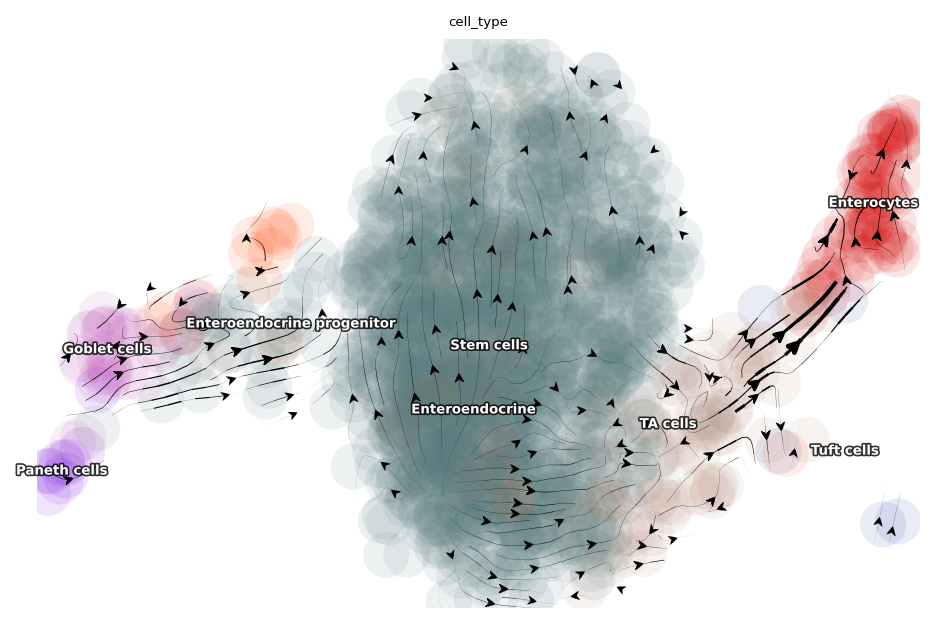

In [17]:
# CSP with steady-state
dyn.pl.streamline_plot(adata_CSPss, color='cell_type', basis='umap_ori', save_show_or_return='show',
                       save_kwargs={'prefix': 'organoid_umap_cspss', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

<Figure size 600x400 with 0 Axes>

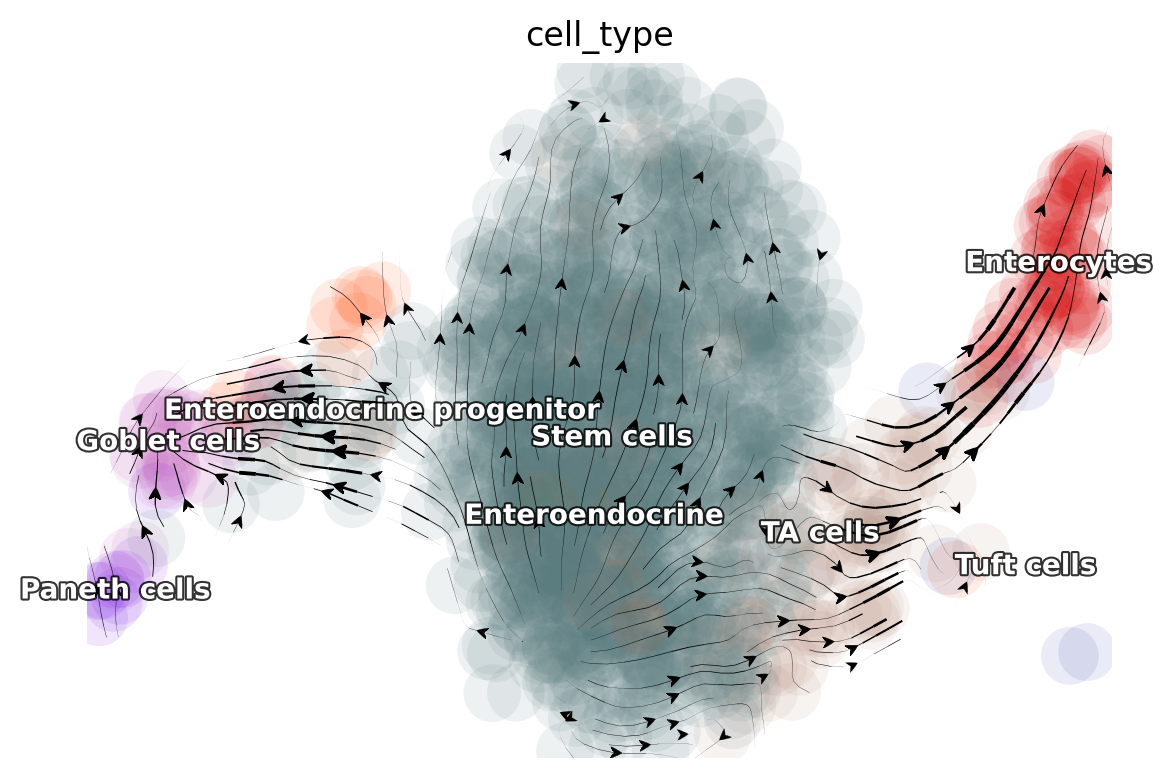

In [18]:
# Dynamo
dyn.pl.streamline_plot(adata_Dynamo, color='cell_type', basis='umap_ori', save_show_or_return='show',
                       save_kwargs={'prefix': 'organoid_umap_dynamo', 'ext': 'png',
                                    "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize)

### Plot the inferred results of $\gamma_{t}$ of the two methods

In [14]:
gamma_CSPss = adata_CSPss.var['gamma'].values
gamma_Dynamo = adata_Dynamo.var['gamma'].values

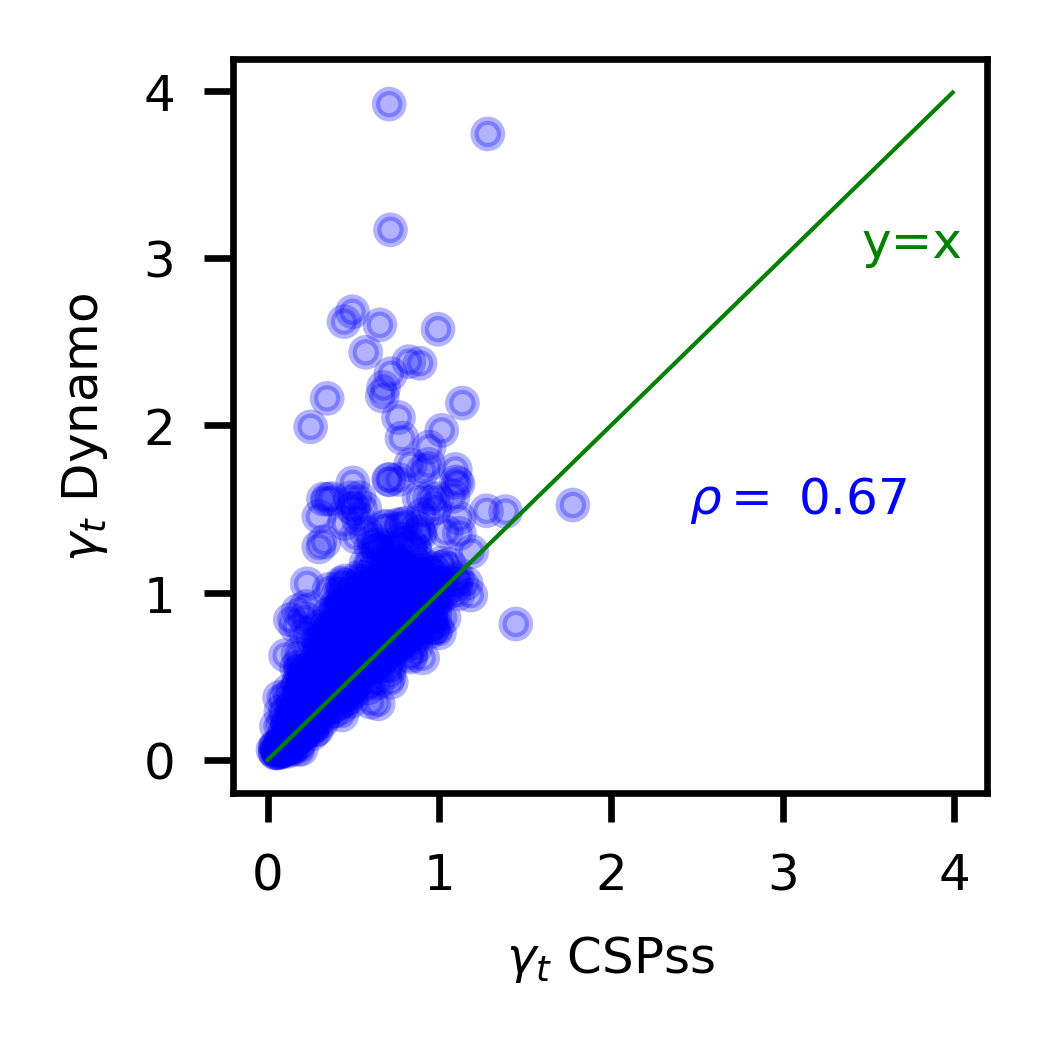

In [15]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 300

gamma_CSPss = gamma_CSPss.astype('float')
gamma_Dynamo = gamma_Dynamo.astype('float')


range_min = 0
range_max = 4
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_CSPss), np.isfinite(gamma_Dynamo))
# correlation coefficient between all the genes
rho = np.corrcoef(gamma_CSPss[index_no_nan], gamma_Dynamo[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(gamma_CSPss, gamma_Dynamo, color='blue', s=scatter_size * np.ones(len(gamma_CSPss)), alpha=alpha)
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho=$ %4.2f' % rho[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.xlabel('$\gamma_t$ CSPss')
plt.ylabel('$\gamma_t$ Dynamo')
plt.grid(False)
# plt.savefig('./one-shot/comp/organoid.pdf',dpi=dpi, bbox_inches="tight")
plt.show()